# Machine Learning I, Programming Exercise 6

## 1. Label Smoothing
In the last programming exercise, we introduced the *cross entropy* loss as an extension of the binary log loss from the lecture. For the output $\mathbf{z} = f(\mathbf{x} \in \mathbb{R}^k$ of our classifier $f: \mathcal{X} \to \mathbb{R}^k$ and $\mathbf{x}$'s true label $y \in \{1, \ldots, k\}$, we defined it like this:
\begin{equation*}
    \ell(\mathbf{z}, y) = -\log(\operatorname{softmax}(\mathbf{z})_y).
\end{equation*}
Note that this value is minimized as $\operatorname{softmax}(\mathbf{z})_y \to 1$. For this, the difference between $\mathbf{z}_y$ and the other elements of $\mathbf{z}$ must be very large. The problematic part about this is that the network is encouraged to make predictions with a very high confidence, which can lead to overfitting.

However, we can yet again extend the cross entropy loss by using a vector-valued ground-truth label $\mathbf{y} \in [0,1]^k$ with $\sum_{i=1}^{k} y_i = 1$ and the following formulation of the cross entropy loss:
\begin{equation*}
    \ell(\mathbf{y}, \mathbf{z}) = -\sum_{i=1}^{k} y_i \log\left(\operatorname{softmax}\left(\mathbf{z}\right)_i\right).
\end{equation*}
If the true label is $c \in \{1, \ldots, k\}$, we can recover the previous formulation by setting $y_c = 1$ and $y_i = 0$ for all $i \in \{1, \ldots, k\} \setminus \{c\}$. This is called *one-hot* encoding of $c$.

The idea of *label smoothing* (first proposed in [this paper](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Szegedy_Rethinking_the_Inception_CVPR_2016_paper.pdf) by Szegedy et al.) is to avoid using a one-hot encoded vector as the target label. Instead, one chooses $\varepsilon \in [0,1]$ and then builds the vector $\mathbf{y}$ with
\begin{equation*}
    y_c = \frac{\varepsilon}{k} + (1-\varepsilon) \quad \text{and} \quad y_i = \frac{\varepsilon}{k} \text{ for all } i \in \{1, \ldots, k\} \setminus \{c\}.
\end{equation*}
The authors have found that this is an effective and cheap way to prevent the model from becoming too confident and possibly overfitting. Since then, it has become a widely adopted method of regularization in the machine learning research community.

1. Unlike other deep learning frameworks, PyTorch does not support label smoothing out of the box. Hence, it is your job to implement label smoothing in a custom module. Writing a custom module, layer or loss works in exactly the same way as writing your own network: subclass `torch.nn.Module` and override the `forward` method. Note that the forward method must take two inputs here: the networks prediction $\mathbf{z}$ and the ground truth label $c \in \{1, \ldots, k\}$ in that order. It should also be possible to specify the 'smoothness' parameter $\varepsilon$ when instantiating the module.

   Note that PyTorch generally operates with batches of data insted of single points. This is usually not much of a problem, since it can be handeled transparently, but the output of a loss' `forward` function is expected to be a scalar. Therefore, you need to compute the loss for each data point in the batch separately and the return the average loss over the batch. More precisely, given a batch of data $B = \{(\mathbf{x}^{(1)}, c^{(1)}), (\mathbf{x}^{(2)}, c^{(2)}), \ldots, (\mathbf{x}^{(n)}, c^{(\lvert B \rvert)})\} \subseteq \mathcal{X} \times \{1, \ldots, k\}$, you need to convert each label $c^{(i)}$ to its correct vector form $\mathbf{y}^{(i)} \in [0, 1]^k$ according to the formulas above and then compute
\begin{equation*}
    L(B) = \frac{1}{B} \sum_{i=1}^{\lvert B \rvert} \ell(f(\mathbf{x}^{(i)}), \mathbf{y}^{(i)}).
\end{equation*}


2. Re-use the code you wrote for parts 2 and 3 of the last programming exercise to train the LeNet-5 network on fashion MNIST once again, but using label smoothing this time. Start with a value of $\varepsilon=0.3$ and see if that changes the accuracy of the network significantly. If you didn't solve those tasks on the last sheet, you can also copy the code from the sample solution that has been uploaded to Olat.


3. After training, we can try and visualize the *confidence* with which the network makes its predictions. Confidence here means the softmax value of the predicted class, or mathematically speaking for input $\mathbf{x} \in \mathcal{X}$ and classifier $f: \mathcal{X} \to \mathbb{R}^k$, we define the confidence as
\begin{equation*}
    \operatorname{conf}(f, \mathbf{x}) = \max_{i \in \{1, \ldots, k\}} \operatorname{softmax}(f(\mathbf{x}))_i.
\end{equation*}

   We will use several [boxplots](https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.boxplot.html) to visualize this quantity by following those steps:
    1. Pass the entire validation set to the trained network from part 2 and record the predicted class label and confidence for each input.
    2. Split the resulting data into two sets: Correctly classified samples, where ground truth and predction match and another set for those, where this is not the case. The following step should then be applied to each of the sets separately.
    3. Partition the data according to the predicted class and draw a boxplot of the confidence values for each partition. Those should be next to each other in the same figure and they should be annotated with the class names they belong to.
   
   This should allow you see which classes the network predicts with most confidence and it is also interesting to see whether the network is just as confident when it is making a mistake.

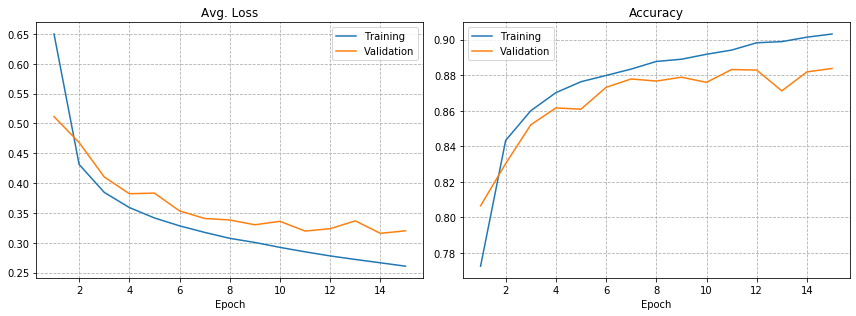

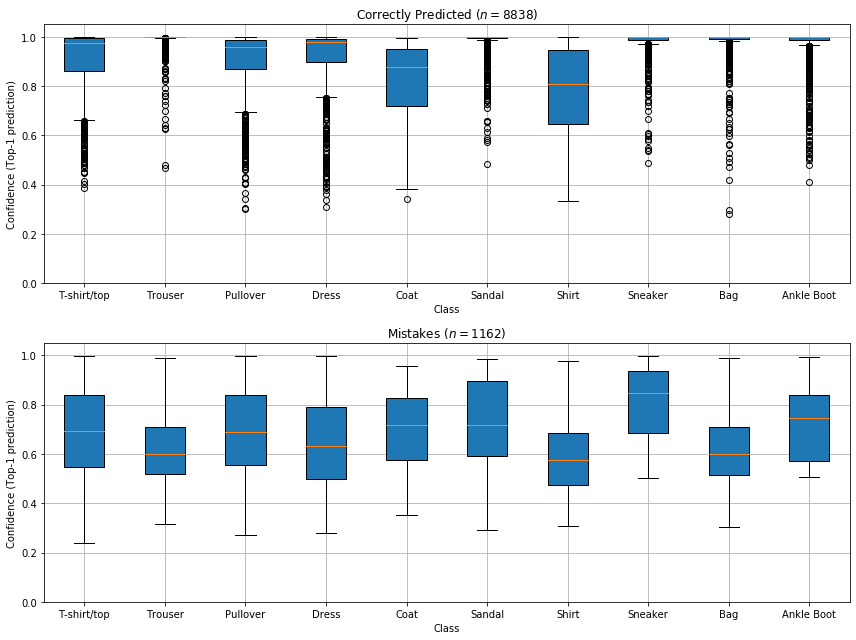

Accuracy of the model on the validation set: 0.8838


In [9]:
%matplotlib inline
import os
import tqdm
import torch
import torchvision
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# ------- old code from previous sheet -----------
class LeNet(torch.nn.Module):
    def __init__(self, activation=None, num_classes=10, in_channels=3):
        super(LeNet, self).__init__()
        pool = torch.nn.AvgPool2d(2, 2, divisor_override=1)

        self.C1 = torch.nn.Conv2d(in_channels, 6, 5, padding=2)
        self.S2 = torch.nn.Sequential(pool, torch.nn.Conv2d(6, 6, 1, groups=6))
        self.C3 = torch.nn.Conv2d(6, 16, 5, groups=2)
        self.S4 = torch.nn.Sequential(pool, torch.nn.Conv2d(16, 16, 1, groups=16))
        
        self.C5 = torch.nn.Linear(16*5*5, 120)
        # Actually, the following would be more faithful to the paper:
        # self.C5 = torch.nn.Conv2d(16, 120, 5)
        self.F6 = torch.nn.Linear(120, 84)
        self.out = torch.nn.Linear(84, num_classes)
        
        self.activation = torch.nn.Identity() if activation is None else activation
        self.num_classes = num_classes

    def forward(self, x):
        # (B, 1, 28, 28)
        x = self.activation(self.C1(x))
        # (B, 6, 28, 28)
        x = self.activation(self.S2(x))
        # (B, 6, 14, 14)
        x = self.activation(self.C3(x))
        # (B, 16, 10, 10)
        x = self.activation(self.S4(x))
        # (B, 16, 5, 5)
        x = x.reshape(-1, 16*5*5)
        # (B, 400)
        x = self.activation(self.C5(x))
        # (B, 120)
        x = self.activation(self.F6(x))
        # (B, 84)
        x = self.out(x)
        # (B, 10)
        return x

def train_model(network, loss, optimizer, train_iter, val_iter, num_epochs, device='cpu', start_epoch=0,
                checkpoints=False, out_dir=None):
    history = dict(train_loss=[], train_acc=[], val_loss=[], val_acc=[])
    best_e, best_acc = 0, 0.0
    for e in range(start_epoch, start_epoch + num_epochs):
        print('Epoch %d of %d:' % (e + 1, start_epoch + num_epochs))

        print('Training:', flush=True)
        network.train()
        iter = tqdm.tqdm(train_iter, desc='Loss: %.3f, Acc: %.2f' % (0, 0))
        correct, total, avg_loss = 0, 0, 0
        for batch_x, batch_y in iter:
            optimizer.zero_grad()
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            res = network(batch_x)
            l = loss(res, batch_y)
            l.backward()
            optimizer.step()
            res = torch.argmax(res, dim=-1)
            correct += torch.sum(res == batch_y).data.cpu().numpy()
            total += batch_x.shape[0]
            avg_loss += l.data.cpu().numpy() * batch_x.shape[0]
            iter.set_description('Loss: %.3f, Acc: %.3f' % (avg_loss / total, correct / total))
        history['train_loss'].append(avg_loss / total)
        history['train_acc'].append(correct / total)

        print('Validation:', flush=True)
        network.eval()
        correct, total, avg_loss = 0, 0, 0
        iter = tqdm.tqdm(val_iter, desc='Loss: %.3f, Acc: %.2f' % (0, 0))
        with torch.no_grad():
            for batch_x, batch_y in iter:
                batch_x = batch_x.to(device)
                batch_y = batch_y.to(device)
                res = network(batch_x)
                l = loss(res, batch_y)
                res = torch.argmax(res, dim=-1)
                correct += torch.sum(res == batch_y).data.cpu().numpy()
                total += batch_x.shape[0]
                avg_loss += l.data.cpu().numpy() * batch_x.shape[0]
                iter.set_description('Loss: %.3f, Acc: %.3f' % (avg_loss / total, correct / total))
        history['val_loss'].append(avg_loss / total)
        acc = correct / total
        history['val_acc'].append(acc)
        if acc > best_acc:
            best_e = e
            best_acc = acc

        if checkpoints and out_dir is not None:
            if not os.path.isdir(out_dir):
                os.makedirs(out_dir)
            save_path = os.path.join(out_dir, 'snap_%03d.pth' % (e+1))
            torch.save(dict(epoch=e, model=network.state_dict(), opt=optimizer.state_dict(), history=history), save_path)
    print('Best Epoch was %d with %.2f%% validation accuracy.' % (best_e+1, best_acc*100))
    return history

def plot_history(history):
    # Plot training and validation curves for avg. loss and accuracy
    fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))
    data = [('Avg. Loss', history['train_loss'], history['val_loss']), 
            ('Accuracy', history['train_acc'], history['val_acc'])]
    for ax, (name, train_hist, val_hist) in zip(axes, data):
        ax.set_title(name)
        ax.set_xlabel('Epoch')
        ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
        ax.grid(linestyle='dashed')
        ax.plot(range(1, len(train_hist)+1), train_hist, label='Training')
        ax.plot(range(1, len(val_hist)+1), val_hist, label='Validation')
        ax.legend()
    
    plt.tight_layout()
    plt.show()
    plt.close(fig)
# ------- old code from previous sheet -----------


class SmoothCrossEntropyLoss(torch.nn.Module):
    def __init__(self, smoothing=0.0):
        super(SmoothCrossEntropyLoss, self).__init__()
        self.smoothing = smoothing

    def forward(self, logits, target):
        shape = logits.shape
        probs = torch.nn.functional.log_softmax(logits, dim=1)
        vec_target = torch.full_like(probs, self.smoothing/shape[1])
        vec_target.scatter_(1, target.view(-1, 1), 1-self.smoothing+self.smoothing/shape[1])

        return torch.dot(-vec_target.flatten(), probs.flatten()) / shape[0]

def average_confidence(network, val_iter, label_dict, device='cpu'):
    # Compute and plot the average confidence for classifier 'network' and
    # dataset 'val_iter' (given as a DataLoader)
    num_classes = len(label_dict)
    labels = []
    predictions = []
    top1_values = []
    
    network.eval()
    with torch.no_grad():
        for batch_x, batch_y in val_iter:
            labels.append(batch_y)
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            res = torch.nn.functional.softmax(network(batch_x), dim=-1)
            #res = network(batch_x)
            max_ind = torch.argmax(res, dim=-1)
            predictions.append(max_ind.data.cpu())
            top1_values.append(res[torch.arange(batch_x.shape[0]), max_ind].data.cpu())
            
    labels = torch.cat(labels)
    predictions = torch.cat(predictions)
    top1_values = torch.cat(top1_values)
    correct = labels == predictions
    correct_data = [top1_values[correct & (predictions==k)].numpy() for k in range(num_classes)]
    wrong_data = [top1_values[(~correct) & (predictions==k)].numpy() for k in range(num_classes)]
    
    # Plot boxplots of top1 logit
    fig, axes = plt.subplots(2, 1, figsize=(12, 9))
    for ax, (name, data) in zip(axes, [('Correctly Predicted', correct_data), ('Mistakes', wrong_data)]):
        ax.set_ylabel('Confidence (Top-1 prediction)')
        ax.set_ylim(0, 1.05)
        ax.set_xlabel('Class')
        ax.set_title(f'{name} ($n={sum(d.size for d in data)}$)')
        ax.boxplot(data, patch_artist=True, labels=label_dict)
        ax.grid()

    fig.tight_layout()
    plt.show()
    plt.close(fig)
    
    print('Accuracy of the model on the validation set:', torch.sum(correct).item() / correct.numel())


# Change this to 'cuda' if you can and want to use a GPU for training
# Otherwise, you can completely ignore this parameter
device = torch.device('cpu')
dataset = torchvision.datasets.FashionMNIST
# Those are the classes in fashion MNIST. Their position in the list corresponds to the numerical class label,
# i.e., class 0 is 'T-shirt/top'
label_dict = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']
batch_size = 64
num_epochs = 15
num_workers = 0  # You can use multiple processes to load the data. 0 means that everything is done in the same process
step_size = 1e-2
regularization=0.0004  # Contols how much the Frobenius norm of the parameters contributes to the final loss
label_smoothing = 0.3  # Controls the amount of label smoothing (epsilon)
checkpoints = True  # Save the model after each epoch of training
out_dir = 'models'  # Folder, where your model checkpoints will be saved
load_path = None  # Don't train the model, but load it from the specified file instead
data_dir = 'data'  # Folder that contains the dataset. If it is not present, 
                   # the dataset will be downloaded into that folder

# Load the training and the test dataset and wrap them in a DataLoader
is_cuda = device.type == 'cuda'
train_dataset = dataset(data_dir, download=True, train=True, transform=torchvision.transforms.ToTensor())
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                                    num_workers=num_workers, pin_memory=is_cuda)
val_dataset = dataset(data_dir, download=True, train=False, transform=torchvision.transforms.ToTensor())
val_iter = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True,
                                    num_workers=num_workers, pin_memory=is_cuda)

# Instantiate the network
activation=lambda x: 1.7159*torch.tanh(x)
network = LeNet(activation=activation, in_channels=1)
network = network.to(device)
loss = SmoothCrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(network.parameters(), lr=step_size, weight_decay=regularization)

start_epoch = 0

if load_path is not None:
    # Load model, optimizer state and history 
    state_dict = torch.load(load_path)
    network.load_state_dict(state_dict['model'])
    optimizer.load_state_dict(state_dict['opt'])
    start_epoch = state_dict['epoch']+1
    history = state_dict['history']
else:
    # Otherwise, we train the model for the specified number of epochs
    history = train_model(network, loss, optimizer, train_iter, val_iter, num_epochs, device,
                      start_epoch, checkpoints=checkpoints, out_dir=out_dir)

# Plot the training history
plot_history(history)

# Compute average confidence
average_confidence(network, val_iter, label_dict, device=device)

## 2. Regularization of kernel SVMs

In the lecture you have learned that $C$ is a regularization parameter for the SVM. However, sometimes $C$ is not important when we use kernels, because the data became linearly separable in the new high-dimensional space. For many kernel SVMs,  tuning the kernel parameters is often the crucial procedure that determines the generalization strength of the model.

In this exercise we will once again have a look at the RBF kernel SVM. It has one parameter, $\sigma > 0$, and the function looks as follows:
\begin{equation*}
    k(\mathbf{x}, \mathbf{x}') = \exp\left(-\frac{1}{2\sigma^2} \lVert \mathbf{x} - \mathbf{x}' \rVert^2\right).
\end{equation*}
$\sigma$ determines the "width" of the RBF kernel, much like the standard deviation $\sigma$ of a normal distribution.

Your tasks will be the following:
1. Run the RBF kernel SVM for 25 different values of $\sigma$ in the range $[10^{-3}, 10^3]$, while fixing $C=1$. Use the [digits dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html#sklearn.datasets.load_digits) like in part 3 of programming exercise 3. You can either use your own SVM implementation from the earlier sheets or the `SVC` class from Scikit-Learn. Modify your `cross_validation` method from ex. 3, s.t. it returns both the training and validation score for each split and use this to obtain scores for the SVM. Choose $k \geq 5$.
2. Make a plot where the x-axis corresponds to the different values of $\sigma$ and the y-axis is the mean of training and/or validation scores that you obtained before when using the corresponding value for $\sigma$. Use two different colors for the training and validation curve and annotate which is which.
3. In the plot of part 2, determine the underfitting region, the overfitting region and the best values for $\sigma$.
4. (optional) Repeat steps 1-3 using a polynomial kernel instead. Here, the variable on the x-axis should be the degree $d$ that is used in the polynomial kernel
\begin{equation*}
    k(\mathbf{x}, \mathbf{x}') = \left(\gamma \langle \mathbf{x}, \mathbf{x}' \rangle + c_0\right)^d.
\end{equation*}
Fix $\gamma=1, c_0=0$ and $C=1$ and try values for $d$ in the range $\{1, \ldots, 10\}$. 

**Hint:** As mentioned in sheet 3, you need to be careful when using the `SVC` class with the RBF kernel. Instead of $\sigma$, this class expects a parameter $\gamma$ and the relation between the two is $\gamma = 1 / (2\sigma^2)$.

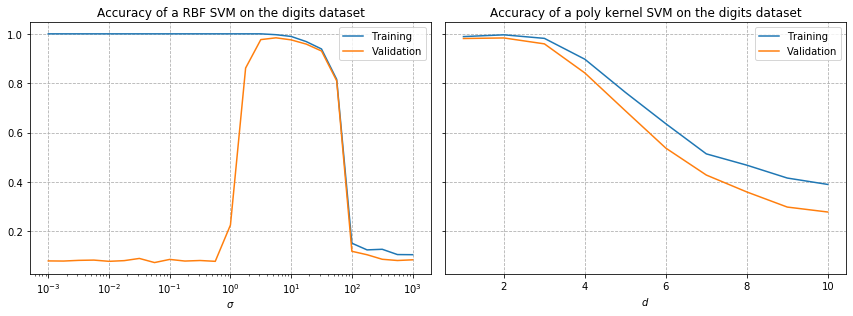

In [12]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC


def cross_validation(clf, X, Y, k=5):   
    n = X.shape[0]
    indices = np.random.permutation(n)
    mask = np.full_like(Y, False, dtype=np.bool)
    fold_sizes = [n//k + int(i<(n%k)) for i in range(k)]
    
    train_scores = []
    val_scores = []
    for fold in range(k):
        start = sum(fold_sizes[:fold])
        end = sum(fold_sizes[:fold+1])
        fold_ind = indices[start:end]
        X_test, Y_test = X[fold_ind], Y[fold_ind]
        mask[...] = True
        mask[fold_ind] = False
        X_train, Y_train = X[mask], Y[mask]
        
        clf.fit(X_train, Y_train)
        train_scores.append(clf.score(X_train, Y_train))
        val_scores.append(clf.score(X_test, Y_test))
    
    return np.array(train_scores), np.array(val_scores)


digits = load_digits()
X, Y = digits.data, digits.target

# Calculate cross validation accuracies (RBF SVM)
train_scores = []
val_scores = []
sigmas = np.power(10, np.linspace(-3, 3, 25))
for sigma in sigmas:
    gamma = 1.0/(2*sigma**2)
    clf = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=1, gamma=gamma, degree=degree))
    # Compute Cross validation score
    train_score, val_score = cross_validation(clf, X, Y, k=5)
    train_scores.append(train_score.mean())
    val_scores.append(val_score.mean())

# Plot the results
fig, axes = plt.subplots(1, 2, figsize=(12, 4.5), sharey=True)
ax = axes[0]
ax.set_title('Accuracy of a RBF SVM on the digits dataset')
ax.set_xlabel('$\sigma$')
ax.set_xscale('log')
ax.grid(linestyle='dashed')
ax.plot(sigmas, train_scores, label='Training')
ax.plot(sigmas, val_scores, label='Validation')
ax.legend()

# Calculate cross validation accuracies (Poly SVM)
train_scores = []
val_scores = []
degrees = np.arange(1, 11)
for degree in degrees:
    clf = make_pipeline(StandardScaler(), SVC(kernel='poly', C=1, degree=degree))
    # Compute Cross validation score
    train_score, val_score = cross_validation(clf, X, Y, k=5)
    train_scores.append(train_score.mean())
    val_scores.append(val_score.mean())

# Plot the results
ax = axes[1]
ax.set_title('Accuracy of a poly kernel SVM on the digits dataset')
ax.set_xlabel('$d$')
ax.grid(linestyle='dashed')
ax.plot(degrees, train_scores, label='Training')
ax.plot(degrees, val_scores, label='Validation')
ax.legend()

plt.tight_layout()
plt.show()
plt.close(fig)